Import packages

In [1]:
import numpy as np
import tensorflow as tf
from matplotlib.pyplot import imshow
import matplotlib.image as mpimg
%matplotlib inline
import matplotlib.pyplot as plt

import keras
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras import models
from keras.models import Model
from keras.models import Sequential
from keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, GlobalAveragePooling1D, GlobalAveragePooling2D, Flatten, BatchNormalization, Dense
from keras.applications.inception_v3 import InceptionV3
from keras.applications import VGG19
from keras.constraints import maxnorm
from keras import optimizers
from keras.optimizers import Adam, SGD , RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau

import pydot
from IPython.display import display
import scipy.misc
from sklearn.metrics import accuracy_score
from PIL import Image
from skimage.transform import resize

import keras.backend as K

Using TensorFlow backend.


In [0]:
from zipfile import ZipFile

with ZipFile('flowers-recognition.zip') as f:
    f.extractall()
    f.close()
    

In [0]:
img_height = 150
img_width = 150
C = 5
batch_size = 64
nb_epochs = 30

Defining our image generators

In [6]:
train_data_dir = '/content/flowers'

train_datagen = ImageDataGenerator(rescale=1./255,
    validation_split=0.05) # set validation split

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle = True,
    class_mode='categorical',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    train_data_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # set as validation data

Found 4109 images belonging to 5 classes.
Found 214 images belonging to 5 classes.


Defining our convolutional model

In [7]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
x = base_model.output
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(1024, activation = "relu")(x)
x = Dropout(0.4)(x)
x = BatchNormalization()(x)
x = Dense(256, activation = "relu")(x)
x = Dropout(0.4)(x)
x = BatchNormalization()(x)
preds = Dense(C, activation = "softmax")(x)

model = Model(input = base_model.input, output = preds)

W0803 16:38:59.154297 139937366992768 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0803 16:38:59.215877 139937366992768 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0803 16:38:59.226742 139937366992768 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0803 16:38:59.280740 139937366992768 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



80142336/80134624 [==============================] - 4s 0us/step


W0803 16:39:03.763043 139937366992768 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0803 16:39:03.764690 139937366992768 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0803 16:39:07.239389 139937366992768 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0803 16:39:07.356335 139937366992768 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future ve

In [0]:
for layer in base_model.layers:
    layer.trainable = False

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [0]:
early = EarlyStopping(monitor = 'val_acc', min_delta = 0, 
                      patience = 10, verbose= 1 , mode = 'auto')

In [11]:
model.compile(loss = "categorical_crossentropy", 
              optimizer = SGD(lr=0.01, momentum=0.9, decay=1e-6, nesterov=True), 
              metrics=["accuracy"])

W0803 16:39:36.948174 139937366992768 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [12]:
H = model.fit_generator(train_generator, 
                        epochs=nb_epochs, 
                        validation_data = train_generator, 
                        validation_steps = 214//64, 
                        steps_per_epoch = 4109//64, 
                        callbacks = [early])

W0803 16:39:41.585012 139937366992768 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/30
64/64 [==============================] - 32s 499ms/step - loss: 1.0120 - acc: 0.6385 - val_loss: 0.5711 - val_acc: 0.7865
Epoch 2/30
64/64 [==============================] - 23s 367ms/step - loss: 0.5301 - acc: 0.8101 - val_loss: 0.3178 - val_acc: 0.9062
Epoch 3/30
64/64 [==============================] - 24s 370ms/step - loss: 0.3528 - acc: 0.8792 - val_loss: 0.1592 - val_acc: 0.9583
Epoch 4/30
64/64 [==============================] - 24s 370ms/step - loss: 0.2444 - acc: 0.9144 - val_loss: 0.0665 - val_acc: 0.9948
Epoch 5/30
64/64 [==============================] - 24s 370ms/step - loss: 0.1970 - acc: 0.9322 - val_loss: 0.1004 - val_acc: 0.9740
Epoch 6/30
64/64 [==============================] - 24s 370ms/step - loss: 0.1458 - acc: 0.9534 - val_loss: 0.0350 - val_acc: 0.9948
Epoch 7/30
64/64 [==============================] - 24s 370ms/step - loss: 0.1046 - acc: 0.9673 - val_loss: 0.0252 - val_acc: 0.9896
Epoch 8/30
64/64 [==============================] - 24s 370ms/step - 

Plotting training loss and validation loss over epochs

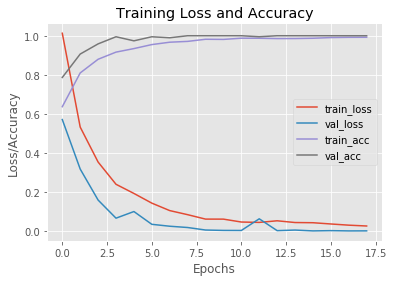

In [22]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 18), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 18), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 18), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, 18), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="best")
plt.savefig("plot.jpg")

In [0]:
model.save("flowers_recognition.h5")

Prediction for user images

Our model predicted that the image contains a sunflower


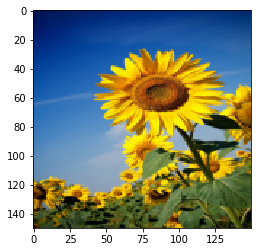

In [19]:
img = plt.imread('my_image.jpg')
img = np.array(resize(img, (150, 150, 3)))
plt.imshow(img)
img = img.reshape(1, 150, 150, 3)
pred = model.predict(img)
classes = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
print("Our model predicted that the image contains a ", end="")
print(classes[np.argmax(pred)])